## Import all the requirements

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, model_selection, metrics
from sklearn.decomposition import TruncatedSVD
from datetime import date

color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
## Import necessary files

In [4]:
train_df = pd.read_csv("../train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("../test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

# train_prd = pd.read_csv("../periods_train.csv", parse_dates=["activation_date","date_from", "date_to"])
# test_prd = pd.read_csv("../periods_test.csv", parse_dates=["activation_date","date_from", "date_to"])
# print("Period Train file rows and columns are : ", train_prd.shape)
# print("Period Test file rows and columns are : ", test_prd.shape)

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [5]:
# train_prd.dtypes

In [6]:
#Number of days an ad was active on the portal
# train_prd['days'] = (train_prd['date_to'] - train_prd['date_from']).dt.days
# test_prd['days'] = (test_prd['date_to'] - test_prd['date_from']).dt.days

# enc = train_prd.groupby('item_id')['days'].agg('sum').astype(np.float32).reset_index()
# enc.head(5)

# train_df = pd.merge(train_df, enc, how='left', on='item_id')
# test_df = pd.merge(test_df, enc, how='left', on='item_id')

In [7]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


# IMPUTE Missing Values for days active


## Create new variables and process the existing ones (train.cs)

In [12]:
# New variables #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

train_df["activation_month"] = train_df["activation_date"].dt.month
test_df["activation_month"] = test_df["activation_date"].dt.month

train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
test_df["title_nwords"] = test_df["title"].apply(lambda x: len(x.split()))

train_df["description"].fillna("NA", inplace=True)
test_df["description"].fillna("NA", inplace=True)
train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))
test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(x.split()))

train_df['param123'] = train_df['param_1'].fillna('') + " " + train_df['param_2'].fillna('') + " " + train_df['param_3'].fillna('') 
test_df['param123'] = test_df['param_1'].fillna('') + " " + test_df['param_2'].fillna('') + " " + test_df['param_3'].fillna('') 

#Impute image_top_1
enc = train_df.groupby('category_name')['image_top_1'].agg(lambda x:x.value_counts().index[0]).astype(np.float32).reset_index()
enc.columns = ['category_name' ,'image_top_1_impute']
#Cross Check values
#enc = train_df.loc[train_df['category_name'] == 'Аквариум'].groupby('image_top_1').agg('count')
#enc.sort_values(['item_id'], ascending=False).head(2)

train_df = pd.merge(train_df, enc, how='left', on='category_name')
test_df = pd.merge(test_df, enc, how='left', on='category_name')

train_df['image_top_1'].fillna(train_df['image_top_1_impute'], inplace=True)
test_df['image_top_1'].fillna(test_df['image_top_1_impute'], inplace=True)

#Impute Days diff
# enc = train_df.groupby('category_name')['days'].agg('median').astype(np.float32).reset_index()
# enc.columns = ['category_name' ,'days_impute']
#Cross Check values
#enc = train_df.loc[train_df['category_name'] == 'Аквариум'].groupby('image_top_1').agg('count')
#enc.sort_values(['item_id'], ascending=False).head(2)

# train_df = pd.merge(train_df, enc, how='left', on='category_name')
# test_df = pd.merge(test_df, enc, how='left', on='category_name')

# train_df['days'].fillna(train_df['days_impute'], inplace=True)
# test_df['days'].fillna(test_df['days_impute'], inplace=True)


#Create image flag 
test_df['image'] = test_df['image'].map(lambda x: 1 if len(str(x)) >0 else 0)
train_df['image'] = train_df['image'].map(lambda x: 1 if len(str(x)) >0 else 0)

# City names are duplicated across region, HT: Branden Murray 
#https://www.kaggle.com/c/avito-demand-prediction/discussion/55630#321751
train_df['city'] = train_df['city'] + "_" + train_df['region']
test_df['city'] = test_df['city'] + "_" + test_df['region']

train_df['price'].fillna(0, inplace=True)
test_df['price'].fillna(0, inplace=True)
train_df['price'] = np.log1p(train_df['price'])
test_df['price'] = np.log1p(test_df['price'])

price_mean = train_df['price'].mean()
price_std = train_df['price'].std()
train_df['price'] = (train_df['price'] - price_mean) / price_std
test_df['price'] = (test_df['price'] - price_mean) / price_std

cat_cols = ['category_name', 'image_top_1']
num_cols = ['price', 'deal_probability']

for c in cat_cols:
    for c2 in num_cols:
        enc = train_df.groupby(c)[c2].agg(['median']).astype(np.float32).reset_index()
        enc.columns = ['_'.join([str(c), str(c2), str(c3)]) if c3 != c else c for c3 in enc.columns]
        train_df = pd.merge(train_df, enc, how='left', on=c)
        test_df = pd.merge(test_df, enc, how='left', on=c)

In [13]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
#ngram_range defines how you want to have words in your dictionary. 
#(min,max) = (1,2) will mean you will have unigrams and bigrms in your vocabulary. 
#Example String: "The old fox"
#Vocabulary: "The", "old", "fox", "The old", "old fox"

full_tfidf = tfidf_vec.fit_transform(train_df['title'].values.tolist() + test_df['title'].values.tolist())
#train_df['title'].values.tolist() this converts all the values in the title column into a list. '+' appends two lists

In [15]:
train_tfidf = tfidf_vec.transform(train_df['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['title'].values.tolist())

### SVD Components ###
n_comp = 5
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [16]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
full_tfidf = tfidf_vec.fit_transform(train_df['description'].values.tolist() + test_df['description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['description'].values.tolist())

### SVD Components ###
n_comp = 5
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [17]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
full_tfidf = tfidf_vec.fit_transform(train_df['param123'].values.tolist() + test_df['param123'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['param123'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['param123'].values.tolist())

### SVD Components ###
n_comp = 5
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_params_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_params_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [18]:
train = train_df
test = test_df

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image", "param_2", "param_3"
                , "param123", "image_top_1_impute"]
train_X = train_df.drop(cols_to_drop + ["deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

In [19]:
train_X.head()

,region,city,parent_category_name,category_name,param_1,price,item_seq_number,user_type,image_top_1,activation_weekday,activation_month,title_nwords,desc_nwords,image_top_1_impute_x,image_top_1_impute_y,category_name_price_median,category_name_deal_probability_median,image_top_1_price_median,image_top_1_deal_probability_median,svd_title_1,svd_title_2,svd_title_3,svd_title_4,svd_title_5,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_params_1,svd_params_2,svd_params_3,svd_params_4,svd_params_5
0,19,477,4,42,249,-0.443110,2,1,1008.0,1,3,3,7,1002.0,1002.0,-0.030557,0.00000,-0.100250,0.00000,0.000223,0.006494,0.006080,0.021883,0.034153,7.300190e-08,0.034083,0.036067,-0.025197,0.001251,-5.657132e-16,-5.294186e-14,3.155931e-14,-1.625810e-14,2.845939e-14
1,17,1370,2,22,122,0.185988,19,1,692.0,6,3,3,7,1431.0,1431.0,0.164431,0.00000,0.275801,0.00000,0.000404,0.010513,0.010396,0.035601,0.055722,6.150848e-08,0.022298,0.027235,-0.026575,-0.003987,1.461320e-01,2.006988e-12,3.648713e-01,8.961137e-01,-1.218028e-02
2,16,1345,0,2,84,0.275880,9,1,3032.0,0,3,2,17,3022.0,3022.0,0.059309,0.00000,0.312685,0.00000,0.000020,0.000027,0.000100,0.000068,0.000276,4.404316e-08,0.147088,-0.063101,0.017553,-0.092230,-3.987856e-16,1.324512e-09,1.391442e-14,-5.135464e-15,1.504977e-12
3,21,982,4,42,38,0.089085,286,0,796.0,5,3,1,3,1002.0,1002.0,-0.030557,0.00000,0.059309,0.11151,0.000050,0.000224,0.000179,0.000205,0.001183,4.112282e-08,0.038238,0.024083,-0.012140,-0.001820,3.951554e-08,4.189315e-14,5.217965e-07,-3.640396e-07,-1.698596e-08
4,4,327,6,0,278,0.995501,3,1,2264.0,3,3,3,4,2264.0,2264.0,1.542222,0.15342,1.418870,0.17209,0.000004,0.000004,0.000029,0.000007,0.000039,1.881553e-07,0.128736,0.147305,-0.200028,-0.085278,6.057445e-06,2.320209e-09,2.539711e-05,-2.516693e-05,9.050432e-07


In [20]:
# #split the train into development and validation sample. Take the last 100K rows as validation sample.
# # Splitting the data for model training#
# dev_X = train_X.iloc[:-100000,:]
# val_X = train_X.iloc[-100000:,:]
# dev_y = train_y[:-100000]
# val_y = train_y[-100000:]
# print(dev_X.shape, val_X.shape, test_X.shape)

In [32]:
#custom function to build the LightGBM model.
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    #0.2272
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 1000,
        "learning_rate" : 0.02,
        "bagging_fraction" : 0.75,
        "feature_fraction" : 0.6,
        "bagging_freq" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1,
        "max_depth": -1,
        "min_child_samples":100,
        'n_jobs' : -1,
    }
    
#     #0.2278
#     params = {
#         "objective" : "regression",
#         "metric" : "rmse",
#         "num_leaves" : 1000,
#         "learning_rate" : 0.02,
#         "bagging_fraction" : 0.75,
#         "feature_fraction" : 0.6,
#         "bagging_freq" : 5,
#         "bagging_seed" : 2018,
#         "verbosity" : -1,
#         "max_depth": -1,
#         "min_child_samples":100,
#         'n_jobs' : -1,
#         'reg_rambda' : 0.5,
#         'n_estimators' : 400,
#        # ,"boosting":"rf"
#     }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 2500, valid_sets=[lgval], early_stopping_rounds=50, verbose_eval=50, evals_result=evals_result)
    
    #model = lgb.cv(params, lgtrain, 1000, early_stopping_rounds=20, verbose_eval=20, stratified=False )
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((1202739, 34), (300685, 34), (1202739,), (300685,))

In [35]:
# Training the model #
import lightgbm as lgb
pred_test, model, evals_result = run_lgb(X_train, y_train, X_test, y_test, test_X)

/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 0.233063
[100]	valid_0's rmse: 0.227251
[150]	valid_0's rmse: 0.225482
[200]	valid_0's rmse: 0.224641
[250]	valid_0's rmse: 0.224172
[300]	valid_0's rmse: 0.223836
[350]	valid_0's rmse: 0.223588
[400]	valid_0's rmse: 0.223423
Did not meet early stopping. Best iteration is:
[400]	valid_0's rmse: 0.223423


In [36]:
import re

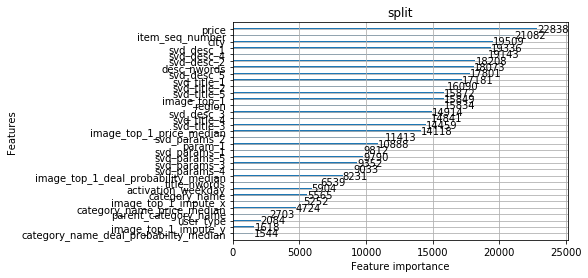

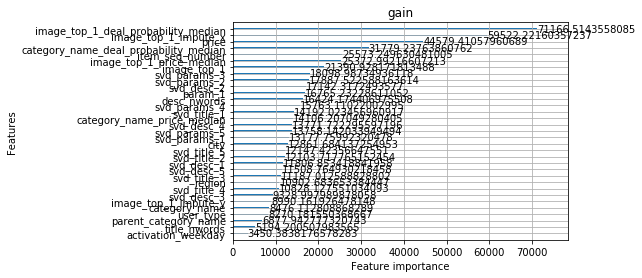

[15834 19509  2703  5565 10888 22838 21082  2084 15849  5904     0  6539
 18073  5252  1618  4724  1544 14118  8231 17181 16090 14459 14841 15872
 19336 18208 14914 19143 17801  9812 11413  9352  9033  9790]
[10902.68365338 12861.68413725  6877.94277732  8476.11280887
 16765.23228611 44579.41057961 25573.24963048  8270.18155037
 21390.92817181  3450.38381766     0.          5194.20050798
 16424.17440698 59522.22160357  8990.16192648 14106.20704928
 31779.23763861 25372.99216607 71166.51435581 14192.02345696
 12103.71776515 11187.01258883 10828.12755103 12147.42356648
 11806.85341884 17142.31724936  9328.99798988 13771.7222956
 11508.76493022 13177.7599232  17887.52258816 18098.98734936
 15763.11022003 13758.14203395]


In [37]:
# Plot importance
lgb.plot_importance(model, importance_type="split", title="split")
plt.show()

lgb.plot_importance(model, importance_type="gain", title='gain')
plt.show()

# Importance values are also available in:
print(model.feature_importance("split"))
print(model.feature_importance("gain"))

In [38]:
# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

! kaggle competitions submit -c avito-demand-prediction -f baseline_lgb.csv -m "Message"

Successfully submitted to Avito Demand Prediction Challenge

In [ ]:
#print(os.listdir("../working"))